# Trabajo Práctico 3: Predicción lineal

27/10/22

Pablo González Leiro

Legajo 60503

In [461]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

## 1. Grabaciones de voz

<h3>Sonido A</h3>

<audio controls>
  <source src="a_16kHz.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>

<h3>Sonido SH</h3>

<audio controls>
  <source src="sh_16kHz.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>

### Dominio temporal

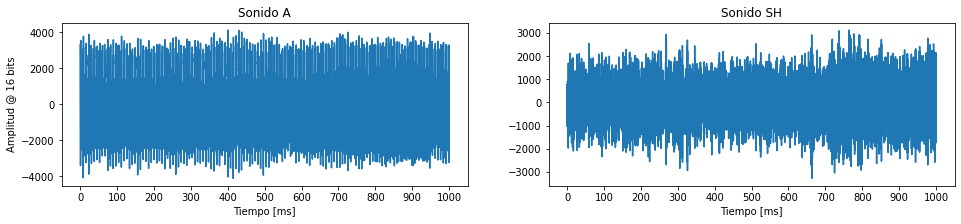

In [462]:
rate, data_a = scipy.io.wavfile.read("a_16kHz.wav")
rate, data_sh = scipy.io.wavfile.read("sh_16kHz.wav")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))
ax1.plot(data_a)
ax2.plot(data_sh)
ax1.set_title("Sonido A")
ax2.set_title("Sonido SH")
ax1.set_xlabel("Tiempo [ms]")
ax2.set_xlabel("Tiempo [ms]")
ax1.set_ylabel("Amplitud @ 16 bits")
ax1.set_xticks([1600*x for x in range(11)])
ax1.set_xticklabels([f"{100*x}" for x in range(11)])
ax2.set_xticks([1600*x for x in range(11)])
ax2.set_xticklabels([f"{100*x}" for x in range(11)])
plt.show()

In [463]:
print(f"mean(data_a) = {np.mean(data_a)}")
Audio(data_a - np.mean(data_a), rate=rate)

mean(data_a) = 0.3005


In [464]:
print(f"mean(data_sh) = {np.mean(data_sh)}")
Audio(data_sh - np.mean(data_sh), rate=rate)

mean(data_sh) = -3.4098125


In [465]:
def autocorrelation(data, N, L):
    x = data[:N]
    lags = [x for x in range(0, L)]
    rxx = scipy.signal.correlate(in1=x,in2=x, mode="full", method="fft") / N
    rxx = rxx[N-1: N+L-1]
    return lags, rxx

def plot_rxx(data, title, N=16000, L=500):
    lags, rxx = autocorrelation(data, N, L)
    fig = plt.figure(figsize=(8,3))
    plt.plot(lags, rxx)
    plt.ylabel(r"$r_{xx}(\tau)$", rotation=0, labelpad=10)
    plt.xlabel(r"$\tau$")
    plt.title(title)
    plt.show()

Se aprecia que la señal A es casi estacionaria dado que la autocorrelación es casi periódica.

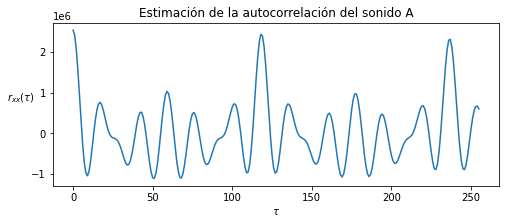

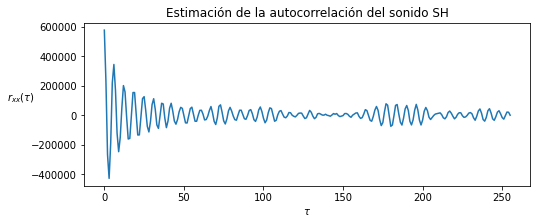

In [466]:
plot_rxx(data_a - np.mean(data_a), "Estimación de la autocorrelación del sonido A", N=16000, L =256)

plot_rxx(data_sh - np.mean(data_sh), "Estimación de la autocorrelación del sonido SH", N=1600, L=256)

### Dominio de la frecuencia

In [467]:
def plot_periodogram(data, rate, title):
    f, Pxx = scipy.signal.welch(data, fs=rate, window="hann", nperseg=len(data)//16)
    plt.figure(figsize=(8,3))
    plt.plot(f, Pxx)
    plt.title(f"Densidad espectral de potencia de {title}")
    plt.ylabel("$PSD~[V^2/Hz]$")
    plt.xlabel("$f~[Hz]$")
    plt.show()

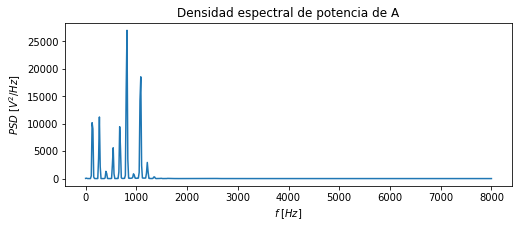

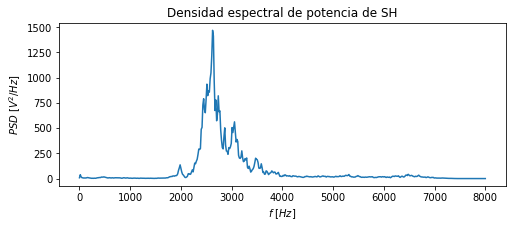

In [468]:
plot_periodogram(data_a, rate, "A")
plot_periodogram(data_sh, rate, "SH")

¿Qué nos la PSD de la autocorrelación?

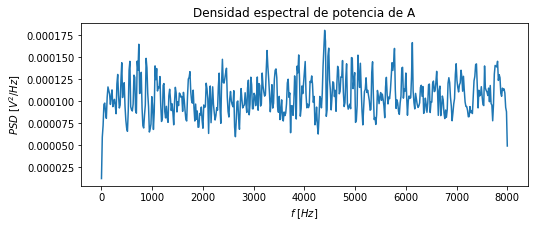

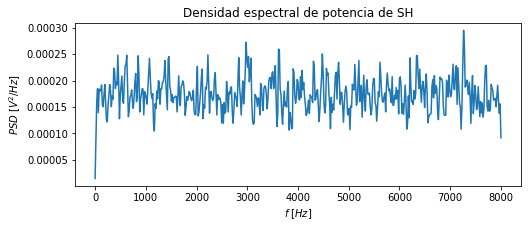

In [469]:
lags, rxx_a = autocorrelation(data_a, N=len(data_a), L=len(data_a))
plot_periodogram(rxx_a, rate, "A")

lags, rxx_sh = autocorrelation(data_sh, N=len(data_sh), L=len(data_sh))
plot_periodogram(rxx_sh, rate, "SH")

## Predictor lineal forward

$\mathbf{R}(n) = E[\mathbf{x}(n)\mathbf{x}^H(n)]$

$\mathbf{r}^f(n) = E[\mathbf{x}(n-1){x}^*(n)]$

Ecuaciones normales:
$\mathbf{R}(n-1)\mathbf{a}_o(n) = -\mathbf{r}^f(n)$

MMSE:
$J_o^f = \sigma_x^2(n) + \mathbf{r}^{fH}(n)\mathbf{a}_o(n)$ 

In [470]:
def flp(data, M, N=16000, L=500):
    data = data - np.mean(data)
    _, rxx = autocorrelation(data, N, L)

    # Input data vector x=x(n-1)

    c=rxx[:M] # c = [r(0) ... r(M-1)]
    #R = scipy.linalg.toeplitz(c=c)
    rf = rxx[1:M+1] # rf = [r(1) ... r(M)]
    # Solve normal equations
    ao = scipy.linalg.solve_toeplitz(c_or_cr=c, b=-rf)
    Jo = rxx[0] + np.dot(np.array(rf), np.array(ao))

    results = dict(data=data, Jo=Jo, rf=rf, ao=ao)
    return results

In [471]:
def plot_mmse_vs_order(data, max_order, title, vlines):
    mmse = []
    order = [M for M in range(1 ,max_order+1,1)]
    for M in order:
        mmse.append(flp(data, M)["Jo"])

    fig = plt.figure(figsize=(12,5))
    for vline in vlines:
        plt.axvline([vline], c='k', linestyle="-.")
    plt.semilogy(order, mmse, '.')
    plt.title(title)
    plt.xlabel("Orden del predictor")
    plt.ylabel("MMSE")
    plt.xticks([M for M in range(10,max_order+1,10)])

    
    return fig

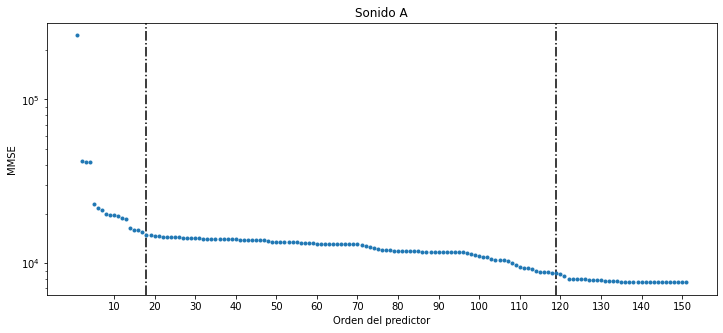

In [472]:
fig_a = plot_mmse_vs_order(data_a, 151, "Sonido A", vlines=[18,119])
plt.show()

Se identifican dos codos en 18 y 119 aproximadamente. El primer codo corresponde al modelo de la forma de la boca, mientras que el segundo coincide con el período de la autocorrelación. Como la señal A es cuasi-periódica, al tomar como tamaño del filtro un período se puede achicar aún más el MMSE.

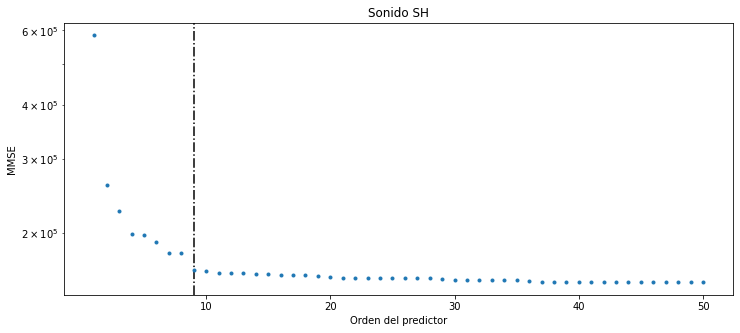

In [473]:
fig_sh = plot_mmse_vs_order(data_sh, 50, "Sonido SH", vlines=[9])
plt.show()

Para el sonido SH, se identifica un codo en M=9.

## Filtro del error de predicción forward

In [474]:
def predict(y, M):
    res = flp(data_a, M)

    # Computar la señal estimada
    ao = res["ao"]
    wf = -ao
    y_est = np.zeros(16000)
    for i in range(16000):
        if i >= M:
            x = y[i-M:i]
        elif M > i:
            x = np.concatenate((np.zeros(M-i),y[:i]))
        y_est[i] = np.dot(x[::-1], wf)

    # Computar el error de predicción forward ef
    ao_bar = np.concatenate(([1], ao))
    ef = np.zeros(16000)
    for i in range(16000):
        if i >= M+1:
            x = y[i-M:i+1]
        elif M > i:
            x = np.concatenate((np.zeros(M-i), y[:i+1]))
        ef[i] = np.dot(x[::-1], ao_bar)

    return y_est, ef

In [475]:
def moving_avg(arr, window_size):
  i = 0
  moving_averages = []
  while i < len(arr) - window_size + 1:
      window_average = np.sum(arr[i:i+window_size]) / window_size
      moving_averages.append(window_average)
      i += 1
  return moving_averages

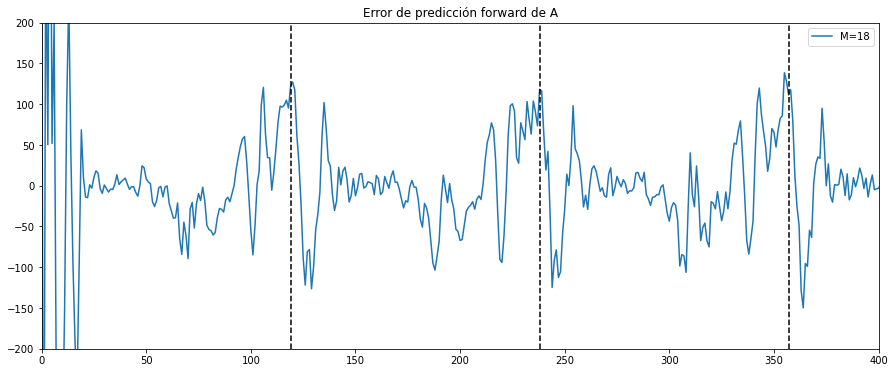

In [476]:
plt.figure(figsize=(15,6))
orders = [2**i for i in range(3,8)]
orders=[18]
for M in orders:
    y_est, ef = predict(data_a, M)
    plt.plot(moving_avg(ef, 5))

plt.ylim((-200,200))
plt.xlim((0,400))
plt.legend([f"M={str(x)}" for x in orders])
plt.axvline([119], c="k", linestyle="--")
plt.axvline([238], c="k", linestyle="--")
plt.axvline([357], c="k", linestyle="--")
plt.title("Error de predicción forward de A")
plt.show()

Podemos asociar el error de predicción forward del sonido A con un tren de impulsos, del mismo período que la autocorrelación.

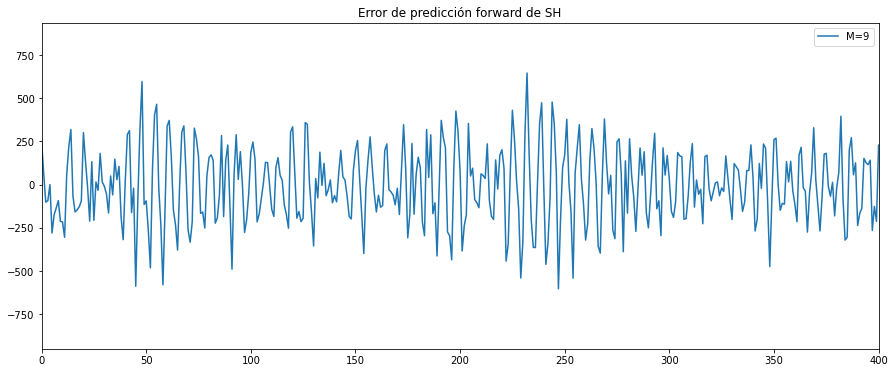

In [477]:
plt.figure(figsize=(15,6))
orders = [2**i for i in range(3,8)]
orders=[9]
for M in orders:
    y_est, ef = predict(data_sh, M)
    plt.plot(moving_avg(ef, 5))

#plt.ylim((-200,200))
plt.xlim((0,400))
plt.legend([f"M={str(x)}" for x in orders])
plt.title("Error de predicción forward de SH")
plt.show()

En cambio, el el error de predicción forward para el sonido SH se asemeja más a ruido blanco, con cambios debidos a las variaciones en la energía de la señal de entrada.

In [478]:
y = data_a - np.mean(data_a)
y_est, ef = predict(y, 18)

Py = np.sum( np.square( y ) ) // 1e6
Pef = np.sum( np.square( ef ) ) // 1e6
Py_est = np.sum( np.square(y_est) ) // 1e6

print(f"Potencia de la señal deseada: {Py}")
print(f"Potencia de la señal estimada: {Py_est}")
print(f"Potencia del error de estimación: {Pef}")
print(f"{Py_est} + {Pef} = {Py_est+Pef} =? {Py}")

Potencia de la señal deseada: 40586.0
Potencia de la señal estimada: 40347.0
Potencia del error de estimación: 235.0
40347.0 + 235.0 = 40582.0 =? 40586.0


### Análisis espectral del error de predicción forward

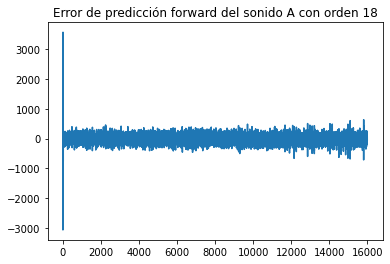

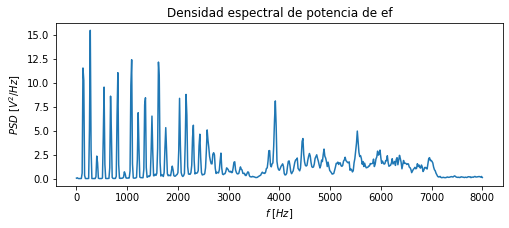

In [479]:
y = data_a - np.mean(data_a)
y_est, ef = predict(y, 18)

plt.plot(ef)
plt.title("Error de predicción forward del sonido A con orden 18")
plt.show()

plot_periodogram(ef, rate, "ef")

Notar los picos en el espectro con ua separación de aproximadamente 16000 Hz / 120 = 133 Hz.

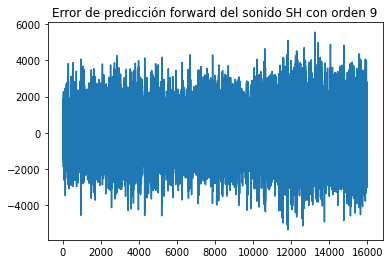

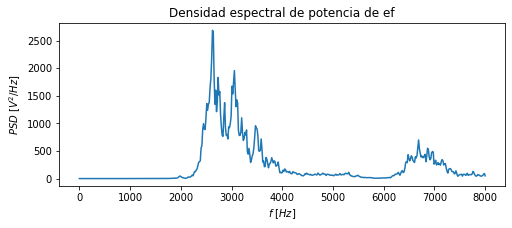

In [480]:
y = data_sh - np.mean(data_sh)
y_est, ef = predict(y, 9)

plt.plot(ef)
plt.title("Error de predicción forward del sonido SH con orden 9")
plt.show()

plot_periodogram(ef, rate, "ef")

In [481]:
print(f"mean(ef) = {np.mean(ef)}")
print(f"var(ef) = {np.var(ef)}")

mean(ef) = -0.18457337886914713
var(ef) = 1961680.6064930316


### Respuesta en frecuencia del filtro del error de predicción

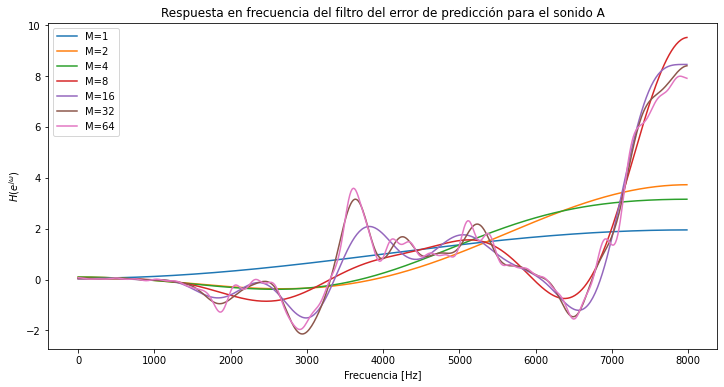

In [482]:
plt.figure(figsize=(12,6))
orders = [2**i for i in range(7)]
for M in orders:
    res = flp(data_a, M)
    ao = res["ao"]
    ao_bar = np.concatenate(([1], ao))
    w, h = scipy.signal.freqz(ao_bar, fs=rate)
    plt.plot(w, np.real(h))
plt.legend([f"M={M}" for M in orders])
plt.title("Respuesta en frecuencia del filtro del error de predicción para el sonido A")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("$H(e^{j\omega})$")
plt.show()

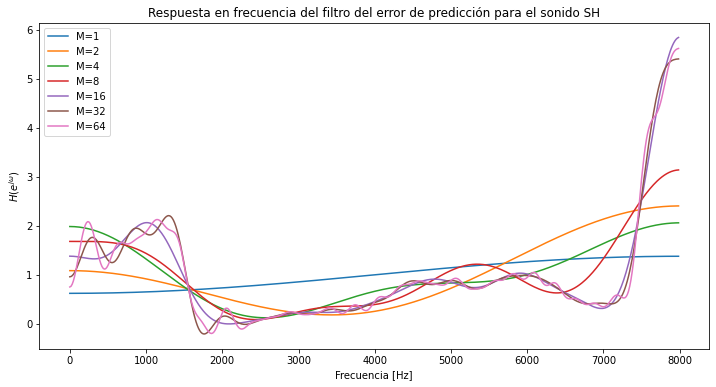

In [483]:
plt.figure(figsize=(12,6))
orders = [2**i for i in range(7)]
for M in orders:
    res = flp(data_sh, M)
    ao = res["ao"]
    ao_bar = np.concatenate(([1], ao))
    w, h = scipy.signal.freqz(ao_bar, fs=rate)
    plt.plot(w, np.real(h))
plt.legend([f"M={M}" for M in orders])
plt.title("Respuesta en frecuencia del filtro del error de predicción para el sonido SH")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("$H(e^{j\omega})$")

plt.show()

Sonido A: Con orden 16, 32 y 64 las respuestas en frecuencia obtenidas son similares, lo cual concuerda con el el hecho de que el primer codo fue localizado para orden 18 aproximadamente. No obstante, hay una diferencia notable a partir del orden 32, que tiene que ver con que el MMSE continua bajando hacia el segundo codo identificado alrededor del orden 118.

Sonido SH: Debido a que hay un solo codo, las respuestas en frecuencia de ordenes 16, 32 y 64 son aún más parecidas entre sí. Además, incluso con orden 8 la respuesta en frecuencia del filtro del error de predicción es similar en la zona de interés para el sonido SH (2 a 4kHz).

### Filtros inversos

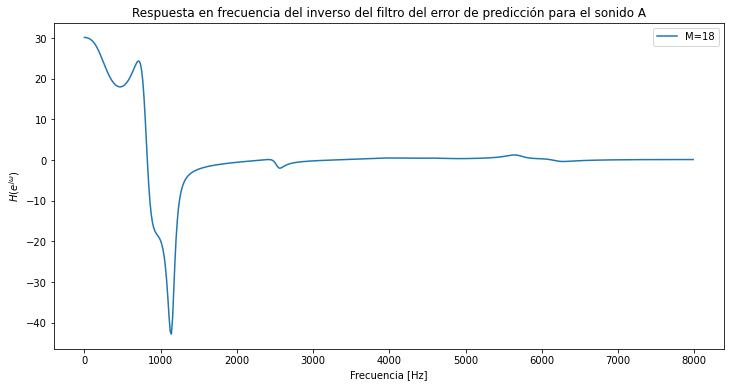

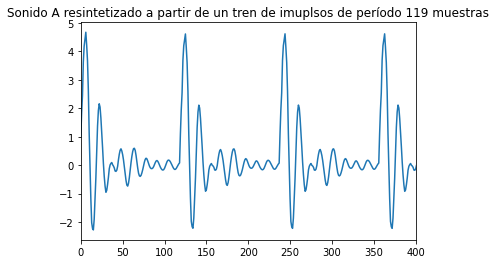

Sonido A resintetizado a partir de un tren de imuplsos de período 119 muestras


In [484]:
plt.figure(figsize=(12,6))
orders = [18]
for M in orders:
    res = flp(data_a, M)
    ao = res["ao"]
    ao_bar = np.concatenate(([1], ao))
    w, h = scipy.signal.freqz(b=1, a=ao_bar, fs=rate)
    plt.plot(w, np.real(h))
plt.legend([f"M={M}" for M in orders])
plt.title("Respuesta en frecuencia del inverso del filtro del error de predicción para el sonido A")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("$H(e^{j\omega})$")
plt.show()

impulse_train = np.zeros(16000)
for idx in range(0, 16000, 119):
    impulse_train += scipy.signal.unit_impulse(16000, idx)

y = scipy.signal.lfilter(b=[1], a=ao_bar, x=impulse_train)
plt.plot(y)
plt.title("Sonido A resintetizado a partir de un tren de imuplsos de período 119 muestras")
plt.xlim((0,400))
plt.show()

print("Sonido A resintetizado a partir de un tren de imuplsos de período 119 muestras")
Audio(y, rate=16000)

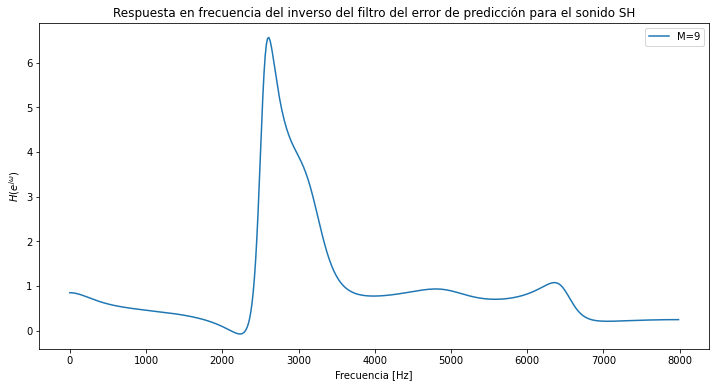

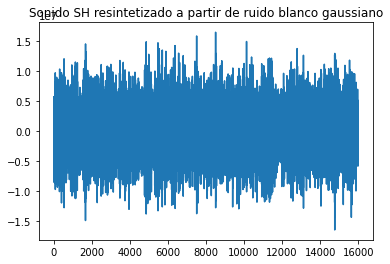

Sonido SH resintetizado a partir de ruido blanco gaussiano


In [485]:
plt.figure(figsize=(12,6))
orders = [9]
for M in orders:
    res = flp(data_sh, M)
    ao = res["ao"]
    ao_bar = np.concatenate(([1], ao))
    w, h = scipy.signal.freqz(b=1, a=ao_bar, fs=rate)
    plt.plot(w, np.real(h))
plt.legend([f"M={M}" for M in orders])
plt.title("Respuesta en frecuencia del inverso del filtro del error de predicción para el sonido SH")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("$H(e^{j\omega})$")
plt.show()

white_noise = np.random.normal(0, 2e6, 16000)
y = scipy.signal.lfilter(b=[1], a=ao_bar, x=white_noise)
plt.plot(y)
plt.title("Sonido SH resintetizado a partir de ruido blanco gaussiano")
plt.show()

print("Sonido SH resintetizado a partir de ruido blanco gaussiano")
Audio(y, rate=16000)

Conclusiones de la comparación entre las grabaciones originales y las resintetizadas:
1. EL sonido A es muy similar, pero a diferencia del original la señal es perfectamente periódica, lo cual se deriva de convolucionar el tren de impulsos con la respuesta impulsiva del filtro inverso del filtro del error de predicción.
2. EL sonido SH no se parece mucho al original. El problema posiblemente radica en que usar ruido blanco como entrada no modela tan bien la señal.

## Vocoder

In [510]:
M = 12
rate, sig = scipy.io.wavfile.read("AudioVocoder.wav")
sig = sig[:-42]
win_len = int(rate * 50e-3)

window = scipy.signal.windows.hann(win_len)
sig_synth = np.zeros(len(sig))

impulse_train = np.zeros(len(sig))
for idx in range(0, len(sig), 160):
    impulse_train += scipy.signal.unit_impulse(len(sig), idx)

white_noise = np.random.normal(0, 2e6, len(sig))

# Recorro toda la señal con un overlap del 50%
for i in range(0, len(sig) - win_len//2, win_len//2):
    # generate block
    block = sig[i:i+win_len]
    block_window = np.multiply(block, window)
    # FLP de orden M para cada bloque    
    res = flp(block_window, M, N=len(block_window), L=M+1)
    ao = res["ao"]
    Jo = res["Jo"] 
    
    # Filtro del error de predicción forward
    ao_bar = np.concatenate(([1], ao))

    # Resintetiza la señal con el filtro inverso del filtro del error de predicción forward
    block_synth = scipy.signal.lfilter(b=[1], a=ao_bar, x=white_noise[i:i+win_len])
    sig_synth[i:i+win_len] += np.multiply(block_synth, window)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3920\3251563177.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, sig = scipy.io.wavfile.read("AudioVocoder.wav")


In [511]:
print("Señal original")
Audio(sig, rate=rate)

Señal original


In [512]:
print("Señal resintetizada")
Audio(sig_synth, rate=rate)

Señal resintetizada


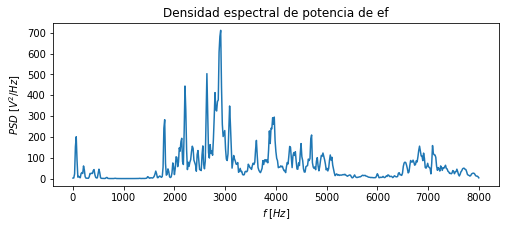

In [516]:
y_est, ef = predict(sig, M=12)
plot_periodogram(ef, 16000, title="ef")

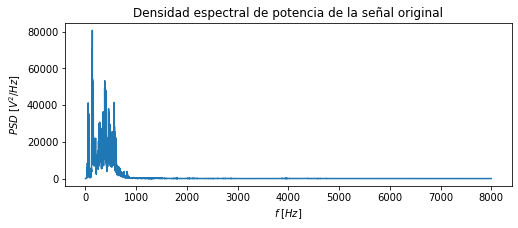

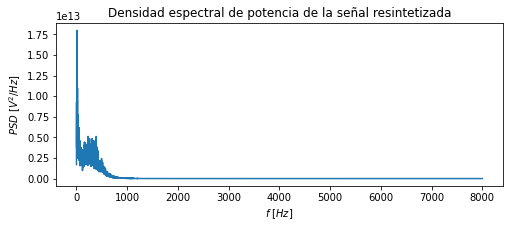

In [518]:
plot_periodogram(sig, 16000, title="la señal original")
plot_periodogram(sig_synth, 16000, title="la señal resintetizada")

Con los periodogramas vemos que las frecuencias bajas aumentaron notablemente respecto de la señal original, generando que la voz sea más grave.